# FWI Example
We will peform FWI using the following steps:
1. [Prepare models](#models)
2. [Setup Constraints](#constraints) with [SetIntersectionProjection](https://github.com/slimgroup/SetIntersectionProjection.jl)
3. [Build a small local compute cluster (2 workers)](#cluster)
    * Take care of some HPC details related to thread affinity
4. [Create source and receivers geometries](#pos)
5. [Build `F`, the JUDI modeling operator](#buildF)
6. [Use `F` to create data for both models](#data)
7. [Visualize data](#vizD)
8. [Assess if data is cycle skipped at the farthest offsets](#cskiped)
9. [Build the `objective` function](#objective)
10. [Perform the FWI using `minConf_PQN`](#inversion) from [JUDI](https://github.com/slimgroup/JUDI.jl)
11. [Visualize velocity models and objective function](#plotres)
12. [Visualize data match](#matchD)
14. [Remove workers](#del)

#### Note on runtime
Warning: this notebook takes more than 1 hour to run for 16 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

In [ ]:
# Add packages needed
# PyPlot is already installed in the environment
# using Pkg
# Pkg.add(["Distributed", "SlimOptim", "JUDI", "SetIntersectionProjection"])

In [2]:
using Distributed, JUDI, SlimOptim, LinearAlgebra, PyPlot, SetIntersectionProjection, Printf

┌ Info: Precompiling SlimOptim [e4c7bc62-5b23-4522-a1b9-71c2be45f1df]
└ @ Base loading.jl:1278


## 1. Prepare models <a id='models'></a>

In [3]:
n = (251, 251) # nx, nz
d = (15., 15.) # hx, hz
o = (0., 0.); # ox, oz

In [4]:
# Squared slowness
m = 1.5f0^(-2) * ones(Float32, n)
m[101:150, 101:150] .= 1.7f0^(-2)
m0 = 1/1.5^2 * ones(Float32, n);

In [5]:
model = Model(n,d,o,m)
model0 = Model(n,d,o,m0);

## Visualize

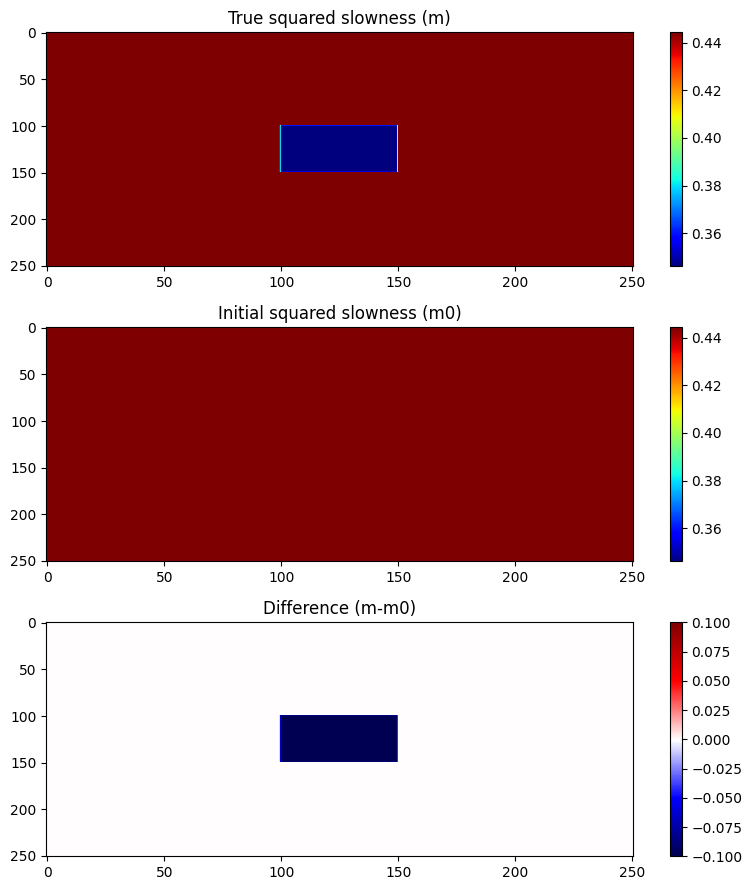

In [6]:
figure(figsize=(8,9))
vmin,vmax = extrema(m)
dmin,dmax = -.1,.1

subplot(3,1,1); imshow(m,aspect="auto",cmap="jet"); 
colorbar(); clim(vmin,vmax); title("True squared slowness (m)")

subplot(3,1,2); imshow(m0,aspect="auto",cmap="jet");
colorbar(); clim(vmin,vmax); title("Initial squared slowness (m0)");

subplot(3,1,3); imshow(m.-m0,aspect="auto",cmap="seismic");
colorbar(); clim(dmin,dmax); title("Difference (m-m0)");

tight_layout()

## 2. Setup Constraints with [SetIntersectionProjection](https://github.com/slimgroup/SetIntersectionProjection.jl) <a id='constraints'></a>

In [7]:
options=PARSDMM_options()
options.FL=Float32
options=default_PARSDMM_options(options,options.FL)
constraint = Vector{SetIntersectionProjection.set_definitions}()
constraint2 = Vector{SetIntersectionProjection.set_definitions}()

set_definitions[]

We setup two constaints:
- Bounds that limit maximum and minimum velocity
- TV, that limits variation and force a piece-wise constant structure

In [8]:
#bounds:
m_min = 0 .* m .+ minimum(m).*.5
m_max = 0 .* m .+ maximum(m)
set_type = "bounds"
TD_OP = "identity"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint, set_definitions(set_type,TD_OP,vec(m_min),vec(m_max),app_mode,custom_TD_OP));
push!(constraint2, set_definitions(set_type,TD_OP,vec(m_min),vec(m_max),app_mode,custom_TD_OP));

In [9]:
#TV
(TV,dummy1,dummy2,dummy3) = get_TD_operator(model0,"TV",options.FL)
m_min = 0.0
m_max = norm(TV*vec(m),1) * .5
set_type = "l1"
TD_OP = "TV"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP));

In [10]:
#set up constraints with bounds only, precompute some things and define projector
(P_sub2,TD_OP2,set_Prop2) = setup_constraints(constraint2, model0,options.FL)
(TD_OP2,AtA2,l2,y2) = PARSDMM_precompute_distribute(TD_OP2,set_Prop2,model0,options)
options2 = deepcopy(options)
options2.rho_ini = ones(length(TD_OP2))*10.0

proj_intersection2 = x-> PARSDMM(x, AtA2, TD_OP2, set_Prop2, P_sub2, model0, options2)  

# Projection function
function prj2(input)
    input = Float32.(input)
    (x,dummy1,dummy2,dymmy3) = proj_intersection2(vec(input))
    return x
end

prj2 (generic function with 1 method)

In [11]:
#set up constraints with bounds and TV
(P_sub,TD_OP,set_Prop) = setup_constraints(constraint, model0,options.FL)
(TD_OP,AtA,l,y) = PARSDMM_precompute_distribute(TD_OP,set_Prop,model0,options)
options.rho_ini = ones(length(TD_OP))*10.0

proj_intersection = x-> PARSDMM(x, AtA, TD_OP, set_Prop, P_sub, model0, options)

# Projection function
function prj(input)
    input = Float32.(input)
    (x,dummy1,dummy2,dymmy3) = proj_intersection(vec(input))
    return x
end

prj (generic function with 1 method)

## 3. Build a small local compute cluster (2 workers)  <a id='cluster'></a>

#### Setup OMP environment variables for the cluster

In the distributed compute case the workers that we add would be on different hardware, and we might add tens of workers in 2D and hundreds in 3D. Here we run on a single machine with only 2 workers, and so we need to be careful with details related to high performance computing. If we did not specify thread affinity, the two workers would compete for the same physical cores and the modeling would be *incredibly* slow.

We spin up the small 2-worker cluster by calling `addprocs(2)`, and because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"` we will see the OMP environment printed out on each worker. In that output (below) we can verify that half of the total threads (44/2 = 22) are assigned to each socket on this 2 socket system. You can obtain more details about the hardware with the shell command `lscpu`.

We set four environment variables related to OpenMP:
* `OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker
* `OMP_PROC_BIND` specifies that threads should be bound to physical cores
* `OMP_NUM_THREADS` specifies the number of threads per workers is 1/2 the number of physical cores
* `GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker

If you run the shell command `top` during execution, you will see 3 julia processes: the main process and two workers. The two workers should generally have about 50% of the system, and `load average` should tend towards the physical number of cores.

In [12]:
nthread = Sys.CPU_THREADS
nw = 2

ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread, nw))" 
addprocs(nw)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, div(nthread, nw)
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, div(nthread, nw)) = (0, 3, 4)
(place1, place2, div(nthread, nw)) = (4, 7, 4)


In [13]:
@everywhere using DrWatson
@everywhere @quickactivate "ConstrainedFWIExamples"
@everywhere using Distributed, JUDI.TimeModeling, LinearAlgebra

      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '4'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = '{0},{1},{2},{3}'
      From worker 2:	  OMP_STACKSIZE = '0'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 2:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From worker 2:	OPENMP DISPLAY ENVIRONMENT END
      From worker 3:	
      From worker 3:	OPENMP DISPLAY

## 4. Create source and receivers geometries <a id='pos'></a>
We use 8 shot locations evenly distributed across the left of the model.

In [14]:
tn = 4000  # Recording time in ms
dt = 2f0  # Shot record sampling rate in ms
f0 = 0.005 # Peak frquency in kHz

0.005

In [15]:
nsrc = 8
xsrc = convertToCell(d[1].*ones(Float32, nsrc))
ysrc = convertToCell(range(0f0, stop = 0f0, length = nsrc))
zsrc = convertToCell(range(0f0, (n[2] - 1)*d[2], length=nsrc))
src_geom = Geometry(xsrc, ysrc, zsrc; dt=dt, t=tn);

In [16]:
nrec = 251
xrec = (n[1] - 2)*d[1] .* ones(Float32, nrec)
yrec = 0f0
zrec = convertToCell(range(0f0, (n[2] - 1)*d[2], length=nrec))
rec_geom = Geometry(xrec, yrec, zrec; dt=dt, t=tn, nsrc=nsrc);

#### Visualize geometry

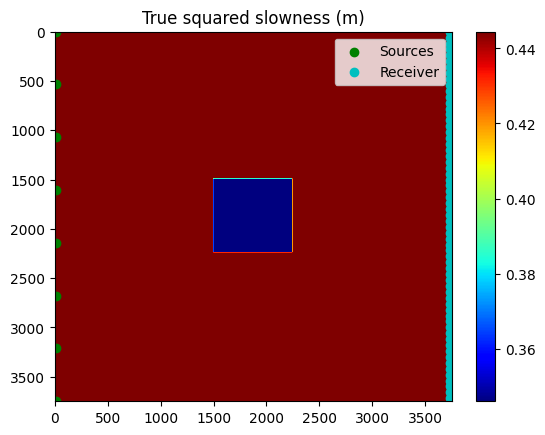

PyObject <matplotlib.legend.Legend object at 0x7fadef01f2b0>

In [17]:
figure()
vmin,vmax = extrema(m)
dmin,dmax = -.1,.1

imshow(m,aspect="auto",cmap="jet", extent=[0, 3750, 3750, 0]); 
colorbar(); clim(vmin,vmax); title("True squared slowness (m)")
scatter(xsrc, zsrc, c="g", label="Sources")
scatter(xrec[1:4:end], zrec[1:4:end], c="c", label="Receiver")
legend()

## 5. Build `F`, the JUDI modeling operator <a id='buildF'></a>

In [18]:
# True model operator
ntComp = get_computational_nt(src_geom, rec_geom, model)
info = Info(prod(n), nsrc, ntComp)
F = judiModeling(info, model, src_geom, rec_geom)

# Intial model operator
ntComp = get_computational_nt(src_geom, rec_geom, model0)
info = Info(prod(n), nsrc,ntComp)
F0 = judiModeling(info, model0, src_geom, rec_geom);

In [19]:
# Source function
fsrc = judiVector(src_geom, ricker_wavelet(tn, dt, f0));

## 6. Use `F` to create the data in both models <a id='data'></a>

In [20]:
t1 = @elapsed begin
    dobs = F*fsrc;
end
@info @sprintf("Time in true model; %.2f seconds\n", t1);

t2 = @elapsed begin
    d0 = F0*fsrc;
end
@info @sprintf("Time in init model; %.2f seconds\n", t2);

┌ Info: Time in true model; 18.33 seconds
└ @ Main In[20]:4
┌ Info: Time in init model; 7.30 seconds
└ @ Main In[20]:9


#### Compute the residual data

In [21]:
r = d0 - dobs;

## 7. Visualize data <a id='vizD'></a>

In [22]:
shots = [1,4,8]

3-element Array{Int64,1}:
 1
 4
 8

#### Plot shot gathers for true model, initial model, and residual

The table below describes the data images below. We flip the direction of the residual and modeled data in order to help display the match with the true data.

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual Data<br>(flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Data<br>(flipped)</b></td>
</tr>
</table>

Note that the data modeled in the initial model lacks a lot of reflectivity that is evident in the data modeled in the true model. We expect to recover this missing reflectivity with the FWI.

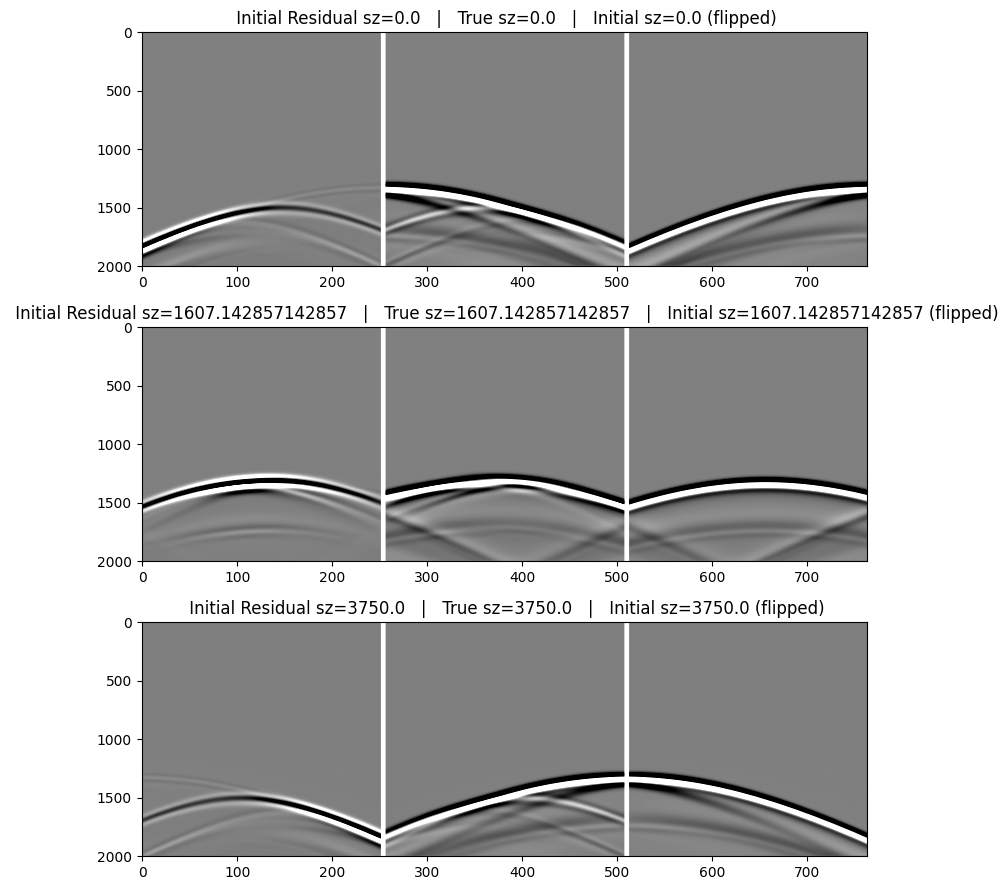

scale = 0.018069569164739018


In [23]:
scale = 10.0 / sqrt(norm(dobs)^2 / length(dobs.data))
@show scale

nzero = 5
pad = ones(Float32,2001,nzero)

figure(figsize=(8,9)); clf()
for (iplot,ishot) in enumerate(shots)
    cat2 = hcat(reverse(r.data[ishot],dims=2), pad, dobs.data[ishot], pad, reverse(d0.data[ishot],dims=2))
    subplot(3,1,iplot);
    imshow(cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial Residual sz=$(zsrc[ishot])   |   True sz=$(zsrc[ishot])   |   Initial sz=$(zsrc[ishot]) (flipped)");
end
tight_layout()

## 8. Assess if data is cycle skipped at the farthest offsets <a id='cskiped'></a>
Next we plot the far offset traces for these three shots in order to assess if the data is cycle skipped. 

You can ovbserve in the plots below that the refraction waveforms (first arrivals) in the initial model are not cycle skipped with respect to the true model, so we can proceed. 

A very significant part of the residual wavefield is actually reflections in this example.

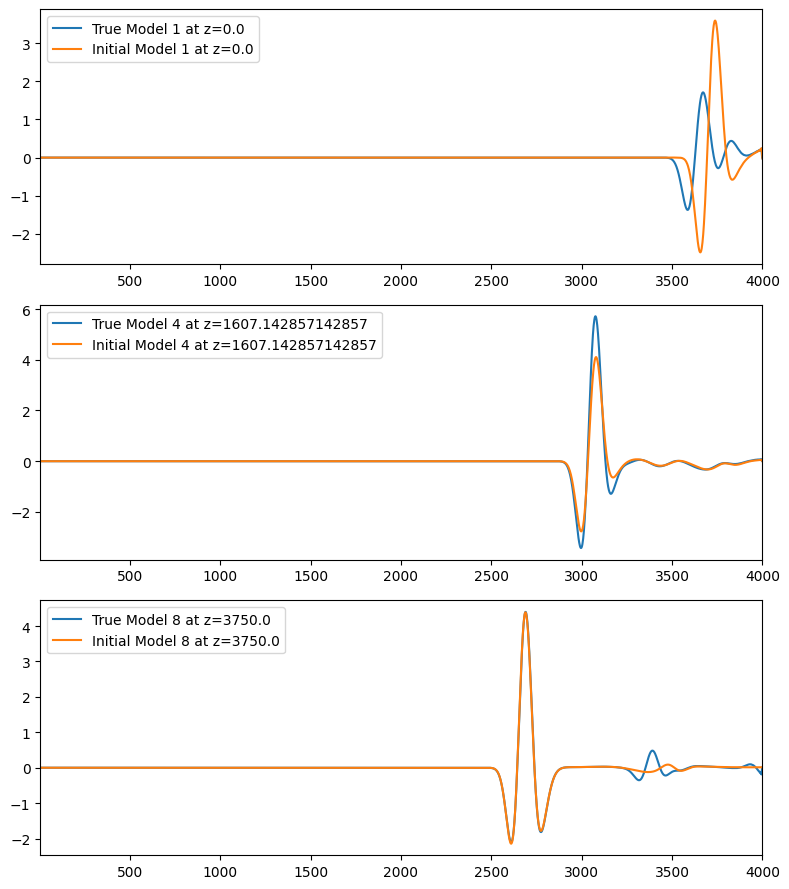

In [24]:
scale = 10.0 / sqrt(norm(dobs)^2 / length(dobs.data))
t = [0.0:dt:tn;]

figure(figsize=(8,9)); clf()
for (iplot,ishot) in enumerate(shots)
    subplot(3,1,iplot);
    plot(t,dobs.data[ishot][:,end],label="True Model $(ishot) at z=$(zsrc[ishot])");
    plot(t,d0.data[ishot][:,end],label="Initial Model $(ishot) at z=$(zsrc[ishot])");
    xlim([4.5,t[end]])
    legend()
end
tight_layout()

## 9. Build the `objective`  functions <a id='objective'></a>

#### Build src/rec positions mask
We use this mask to remove the imprint in gradients of proximity to source locations. The mask is set to 0 wherever a source or receiver is close, and is set to 1 otherwise. Without this mask most of the gradient updates would be concentrated close to sources where the model is correct. 

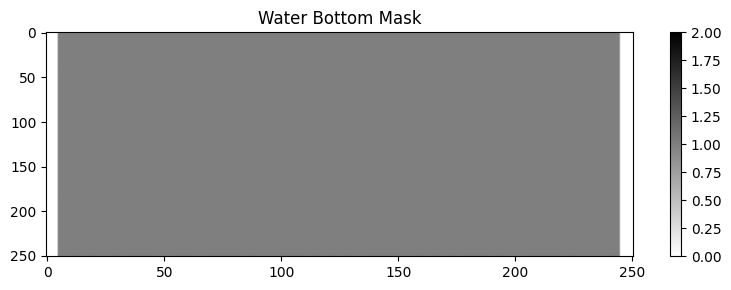

In [25]:
wb_mask = ones(Float32,size(m))
wb_mask[1:5, :] .= 0;
wb_mask[end-5:end, :] .= 0;

figure(figsize=(8,3))
imshow(wb_mask', aspect="auto",cmap="gray_r",clim=[0,+2]);
colorbar();
title("Water Bottom Mask");
tight_layout()

#### Build the `objective` function
This method is called by the solver whenever the gradient is required. Steps in computing the gradient are as follows:
1. Apply the adjoint of the Jacobian to the current residual `J' * [F*v - d]` 
1. Apply simple scaling based on the size of the first gradient, and save to apply to future gradients

In [26]:
# build Jacoian
J = judiJacobian(F0, fsrc)

function objective(F0, G, m, dobs, wb_mask)
    F0.model.m .= m
    t = @elapsed begin
        d0 = F0*fsrc
        if isnothing(G)
            return .5*norm(d0 .- dobs)^2
        end
        G .= J' * (d0 .- dobs)
    end
    G .*= vec(wb_mask)
    ϕ = .5*norm(d0 .- dobs)^2
    if gscale == 0.0
        # compute scalar from first gradient, apply to future gradients
        global gscale = .25 ./ maximum(G) 
        @show gscale
    end
    G .*= gscale
    return ϕ
end

# struct to save the first gradient scalar
gscale = 0f0
f(x) = objective(F0, nothing, x, dobs, wb_mask)
g!(G, x) = objective(F0, G, x, dobs, wb_mask)
fg!(G, x) = objective(F0, G, x, dobs, wb_mask)

fg! (generic function with 1 method)

#### Compute gradient

In [27]:
grad1 = 0f0 .* vec(m0)
tgrad1 = @elapsed begin
    g!(grad1, vec(m0))
    gscale = 0
end
@show tgrad1;

gscale = 3.171329201933767e-5
tgrad1 = 22.281701343


relative evolution to small, exiting PARSDMM (iteration 37)


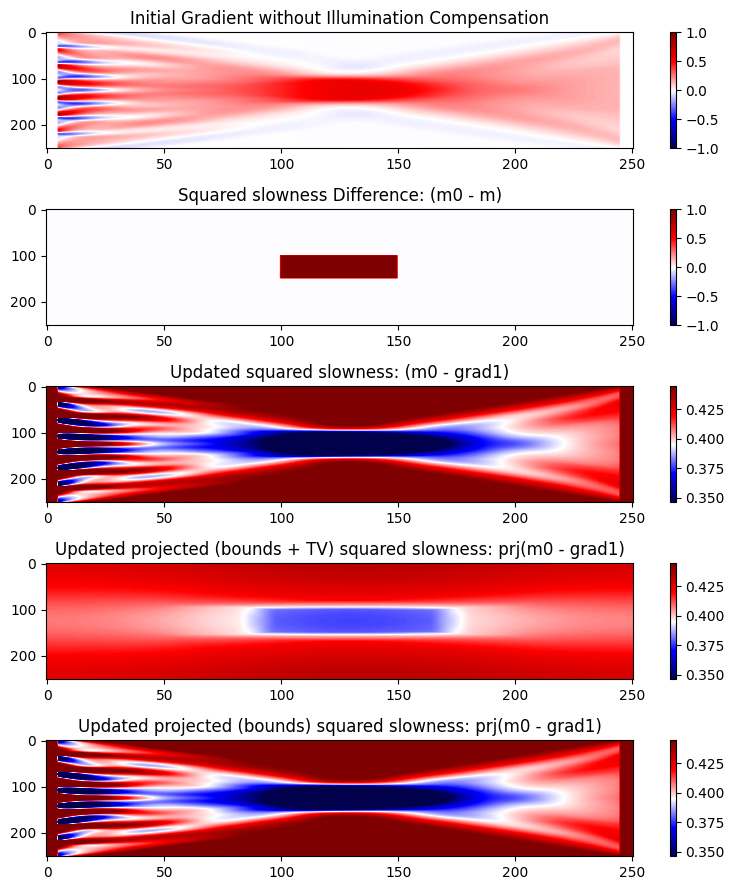

input to PARSDMM is feasible, returning


In [28]:
dm = m0 .- m
grad1 = reshape(grad1, n)
mg2 = reshape(m0 .- grad1, n)
figure(figsize=(8,9))

subplot(5,1,1)
imshow(grad1' ./ maximum(abs,grad1),aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(-1,1);
title("Initial Gradient without Illumination Compensation");

subplot(5,1,2)
imshow(dm ./ maximum(abs,dm),aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(-1,1);
title("Squared slowness Difference: (m0 - m)");

subplot(5,1,3)
imshow(mg2',aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(vmin,vmax)
title("Updated squared slowness: (m0 - grad1)");

subplot(5,1,4)
imshow(reshape(prj(mg2), n)',aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(vmin,vmax)
title("Updated projected (bounds + TV) squared slowness: prj(m0 - grad1)");

subplot(5,1,5)
imshow(reshape(prj2(mg2), n)',aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(vmin,vmax)
title("Updated projected (bounds) squared slowness: prj(m0 - grad1)");

tight_layout()

## 10. Perform the FWI using `minConf_PQN` <a id='inversion'></a>
We will do 10 functions evaluation cost of projected quasi-Newton with two setup:
- Bounds constraints only
- Bounds + tv constrains

In [29]:
# FWI with PQN
niter = 10
gscale = 0f0
options_pqn = pqn_options(progTol=0, store_trace=true, verbose=3, maxIter=niter)

SlimOptim.PQN_params(3, 1.0f-5, 0, 10, 0.0001f0, 10, false, true, true, 1.0f-6, 1.0f-7, 10, false, 20)

In [30]:
sol = pqn(f, g!, fg!, vec(m0), prj, options_pqn);

Running PQN...
Number of L-BFGS Corrections to store: 10
Spectral initialization of SPG: 1
Maximum number of SPG iterations: 10
SPG optimality tolerance: 1.00e-06
SPG progress tolerance: 1.00e-07
PQN optimality tolerance: 1.00e-05
PQN progress tolerance: 0.00e+00
Quadratic initialization of line search: 0
Maximum number of iterations: 10
input to PARSDMM is feasible, returning
gscale = 3.171329201933767e-5
 Iteration   FunEvals  GradEvals Projections     Step Length    Function Val        Opt Cond
relative evolution to small, exiting PARSDMM (iteration 37)
         0          0          0          0     0.00000e+00     8.01092e+05     6.73967e-02
relative evolution to small, exiting PARSDMM (iteration 37)
relative evolution to small, exiting PARSDMM (iteration 37)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 38)
         1          3          2          6     1.00000e-01     5.95612e+05     5.52523e-02
relative evolution to small, exit

In [31]:
sol2 = pqn(f, g!, fg!, vec(m0), prj2, options_pqn);

Running PQN...
Number of L-BFGS Corrections to store: 10
Spectral initialization of SPG: 1
Maximum number of SPG iterations: 10
SPG optimality tolerance: 1.00e-06
SPG progress tolerance: 1.00e-07
PQN optimality tolerance: 1.00e-05
PQN progress tolerance: 0.00e+00
Quadratic initialization of line search: 0
Maximum number of iterations: 10
input to PARSDMM is feasible, returning
 Iteration   FunEvals  GradEvals Projections     Step Length    Function Val        Opt Cond
input to PARSDMM is feasible, returning
         0          0          0          0     0.00000e+00     8.01092e+05     2.50000e-01
input to PARSDMM is feasible, returning
input to PARSDMM is feasible, returning
input to PARSDMM is feasible, returning
input to PARSDMM is feasible, returning
         1          3          2          6     1.00000e-01     4.11118e+05     1.59573e-01
input to PARSDMM is feasible, returning
input to PARSDMM is feasible, returning
input to PARSDMM is feasible, returning
input to PARSDMM is fea

In [32]:
mf = reshape(prj(sol.x), n) # optimal solution
ϕ = sol.ϕ_trace   # cost vs iteration
m1 = sol.x_trace  # model vs iteration
collect(m1[i] = reshape(m1[i], n) for i=1:length(ϕ));

relative evolution to small, exiting PARSDMM (iteration 15)


In [33]:
mf2 = reshape(prj(sol2.x), n) # optimal solution
ϕ2 = sol2.ϕ_trace   # cost vs iteration
m2 = sol2.x_trace  # model vs iteration
collect(m2[i] = reshape(m2[i], n) for i=1:length(ϕ2));

relative evolution to small, exiting PARSDMM (iteration 15)


## 11. Visualize velocity models and objective function  <a id='plotres'></a>

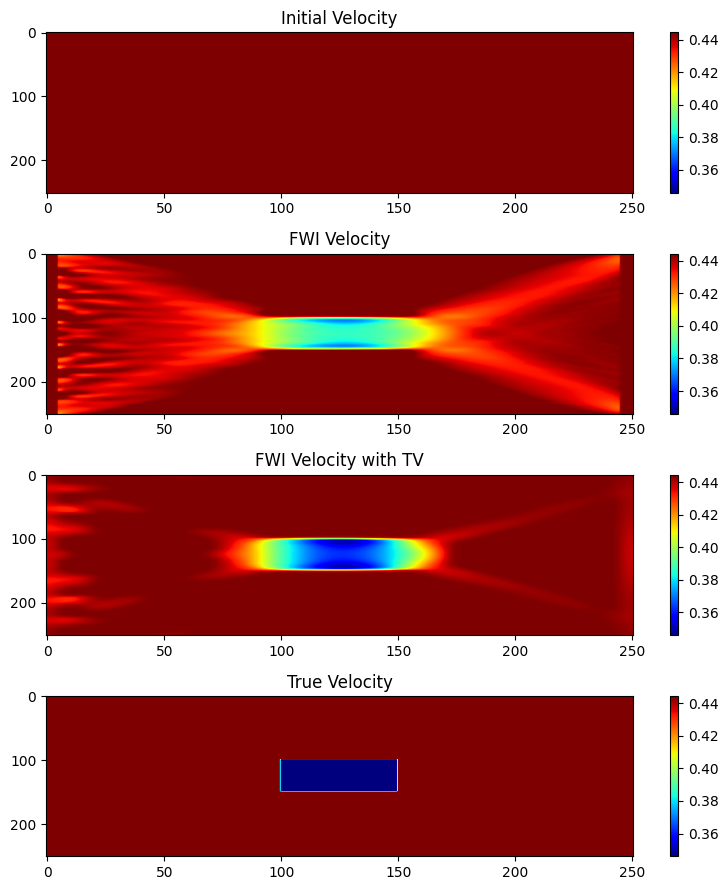

In [34]:
figure(figsize=(8,9)); clf()

subplot(4,1,1);imshow(m0',aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("Initial Velocity");

subplot(4,1,2);imshow(mf2',aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI Velocity");

subplot(4,1,3);imshow(mf',aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI Velocity with TV");

subplot(4,1,4);imshow(m',aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("True Velocity")

tight_layout()

#### Display the velocity difference models 

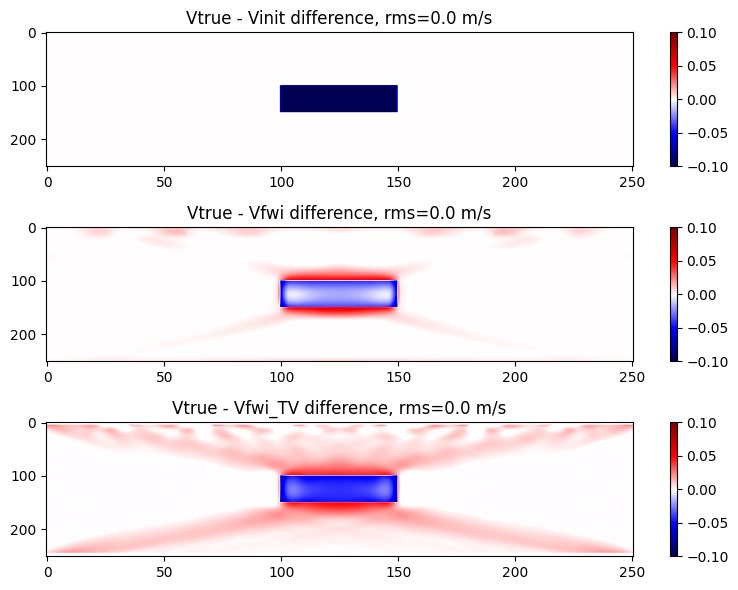

In [35]:
rms_v2 = @sprintf("%.1f m/s", sqrt(norm(m .- m0)^2 / length(m)))
rms_vf = @sprintf("%.1f m/s", sqrt(norm(m .- mf)^2 / length(m)))
rms_vf2 = @sprintf("%.1f m/s", sqrt(norm(m .- mf2)^2 / length(m)))

figure(figsize=(8,6)); clf()

subplot(3,1,1);imshow(m .- m0,aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(dmin,dmax);
title("Vtrue - Vinit difference, rms=$(rms_v2)");

subplot(3,1,2);imshow(m .- mf,aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(dmin,dmax);
title("Vtrue - Vfwi difference, rms=$(rms_vf)");

subplot(3,1,3);imshow(m .- mf2,aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(dmin,dmax);
title("Vtrue - Vfwi_TV difference, rms=$(rms_vf2)");

tight_layout()

#### Display the cost function 

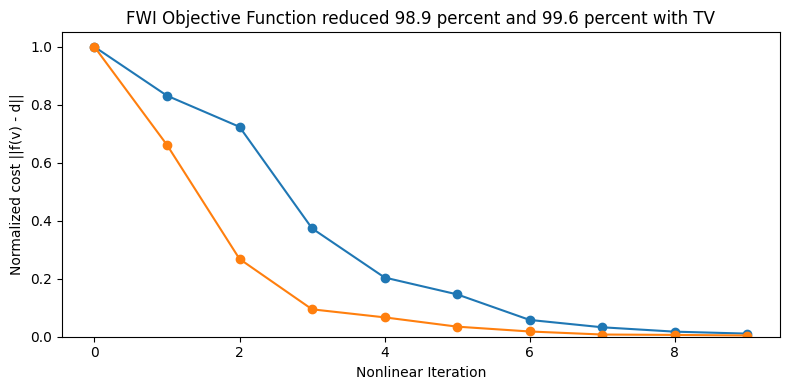

In [36]:
figure(figsize=(8,4)); clf()
iters = [0:1:niter;]
plot(ϕ[2:end] ./ ϕ[2], marker="o", label="FWI_TV")
plot(ϕ2[2:end] ./ ϕ2[2], marker="o", label="FWI")
ylim([0,1.05])
xlabel("Nonlinear Iteration")
ylabel("Normalized cost ||f(v) - d||")
title(@sprintf("FWI Objective Function reduced %.1f percent and %.1f percent with TV",
               100 * (ϕ[2] - ϕ[end]) / ϕ[2], 100 * (ϕ2[2] - ϕ2[end]) / ϕ2[2]));
tight_layout()

#### Display data misfit vs model misfit

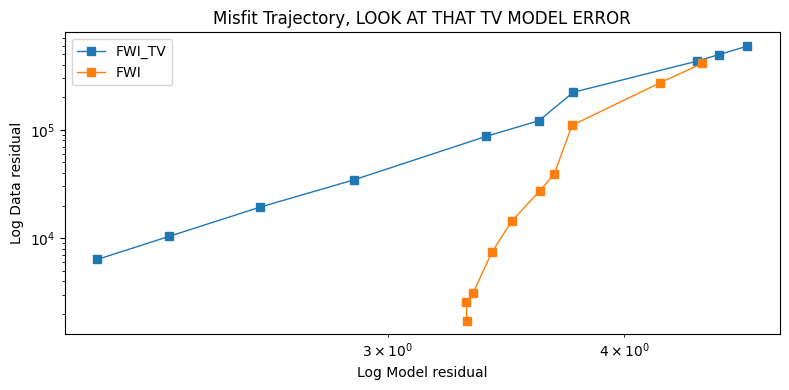

In [37]:
figure(figsize=(8,4)); clf()

c = [norm(m1[i] .- m, 2) for i in 1:length(m1)]
c2 = [norm(m2[i] .- m, 2) for i in 1:length(m2)]
loglog(c[2:end], ϕ[2:end], label="FWI_TV", marker="s", linewidth=1)
loglog(c2[2:end], ϕ2[2:end], label="FWI", marker="s", linewidth=1)
legend()
xlabel("Log Model residual")
ylabel("Log Data residual")
title("Misfit Trajectory, LOOK AT THAT TV MODEL ERROR");
tight_layout()

## 12. Visualize data match <a id='matchD'></a>
#### Generate data in the FWI velocity model

In [38]:
tf = @elapsed begin
    F0.model.m .= vec(mf)
    df = F0*fsrc;
end
@show tf;

tf2 = @elapsed begin
    F0.model.m .= vec(mf2)
    df2 = F0*fsrc;
end
@show tf2;

tf = 8.261754228
tf2 = 8.797445243


#### Compute residuals

In [39]:
rf = df - dobs;
rf2 = df2 - dobs;

#### Plot shot gathers for true, initial model, and fwi models

The table below describes the data images below. We will flip the direction of the residual and modeled data in order to help display the match with the true data. We include the initial data as shown above for easier comparison. 

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual Data<br>(flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Data<br>(flipped)</b></td>
</tr>
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Residual Data<br>(flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Data<br>(flipped)</b></td>
</tr>
</table>

We first make a function to create the plots that we can re-use for the selected shots.

In [40]:
zsrc = trunc.(zsrc; digits=6)
function make_plot(index)
    figure(figsize=(8,6)); clf()
    cat2 = hcat(reverse(r.data[index],dims=2), pad, dobs.data[index], pad, reverse(d0.data[index],dims=2))
    catf = hcat(reverse(rf.data[index],dims=2), pad, dobs.data[index], pad, reverse(df.data[index],dims=2))
    catf2 = hcat(reverse(rf2.data[index],dims=2), pad, dobs.data[index], pad, reverse(df.data[index],dims=2))
    subplot(3,1,1);
    imshow(cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial Residual sz=$(zsrc[index])   ||   True sz=$(zsrc[index])   ||   Initial sz=$(zsrc[index]) (flipped)");
    subplot(3,1,2);
    imshow(catf2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" FWI Residual sz=$(zsrc[index])   ||   True sz=$(zsrc[index])   ||   FWI sz=$(zsrc[index]) (flipped)");
    tight_layout()
    subplot(3,1,3);
    imshow(catf,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("TV FWI Residual sz=$(zsrc[index])   ||   True sz=$(zsrc[index])   ||   FWI sz=$(zsrc[index]) (flipped)");
    tight_layout()
end

make_plot (generic function with 1 method)

#### Data for the 1st shot, generated in the initial and FWI models

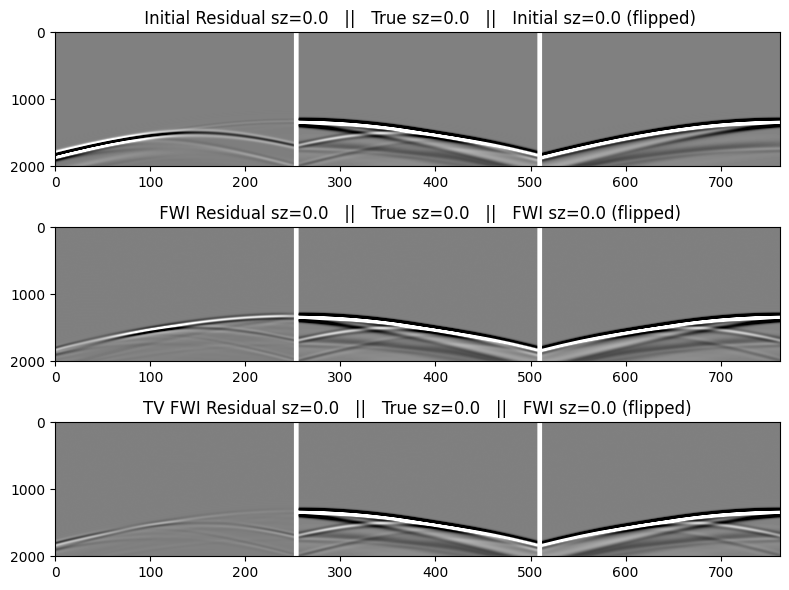

In [41]:
make_plot(1)

#### Data for the 4th shot, generated in the initial and FWI models

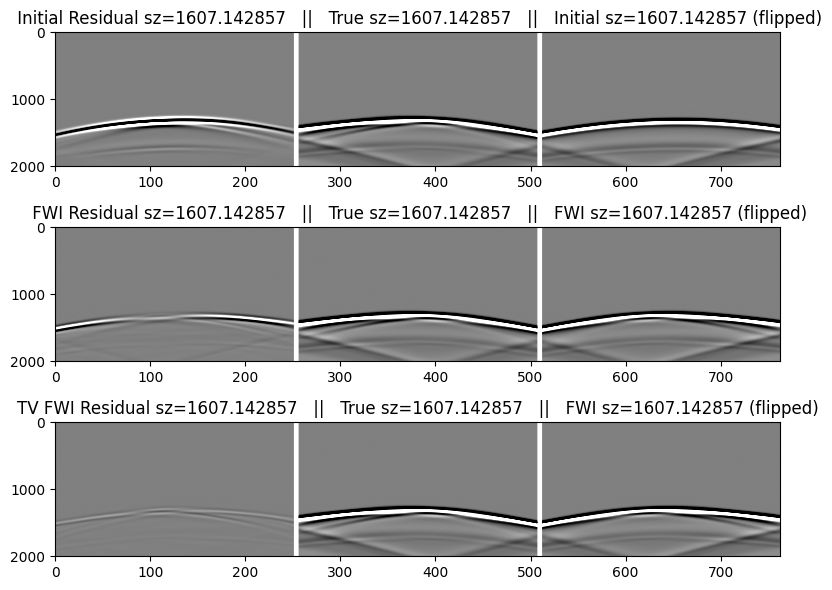

In [42]:
make_plot(4)

#### Data for the 8th shot, generated in the initial and FWI models

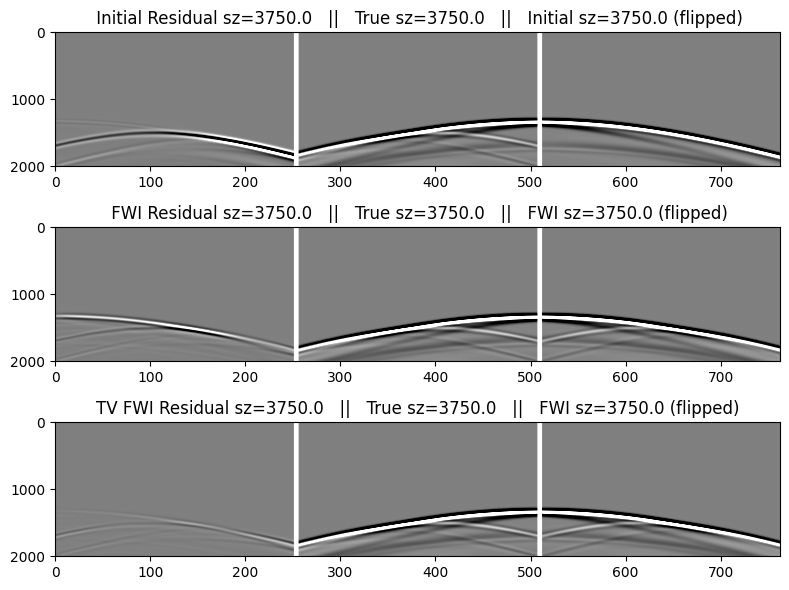

In [43]:
make_plot(8)

## 14. Remove workers <a id='del'></a>

In [44]:
rmprocs(workers());